Import Necessary Libraries

In [1]:
import os
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import re 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    accuracy_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)
import json
from pandas import json_normalize
from datetime import datetime
from matplotlib.patches import Circle

In [2]:
df = pd.read_csv('flattened_telemetry.csv', sep=',', low_memory=False)
df

,_id,ulCarrierFreq,timestamp,id,frame,slot,pci,dlCarrierFreq,ueId,dlMcs,...,ulMcs,rssi,cqi,pucchSnr,puschSnr,rnti,dlBytes,phr,pmi_0,pmi_1
0,67c20d2e037f557dd6e2cd3f,3.750240e+09,2025-02-28 19:23:26.263000064,12345678.0,0.0,0.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67c20d2f037f557dd6e2cd40,3.750240e+09,2025-02-28 19:23:27.263000064,12345678.0,0.0,0.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67c20d30037f557dd6e2cd41,3.750240e+09,2025-02-28 19:23:28.263000064,12345678.0,213.0,4.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67c20d31037f557dd6e2cd42,3.750240e+09,2025-02-28 19:23:29.263000064,12345678.0,313.0,4.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67c20d32037f557dd6e2cd43,3.750240e+09,2025-02-28 19:23:30.263000064,12345678.0,413.0,4.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176428,6811e64dc12140b28bc1344c,3.750240e+09,2025-04-30 08:58:53.132000000,12345678.0,350.0,4.0,0.0,3.750240e+09,0.0,6.0,...,6.0,90.7,15.0,20.0,21.5,f0e1,10641.0,61.0,15.0,1.0
176429,6811e64dc12140b28bc1344c,3.750240e+09,2025-04-30 08:58:53.132000000,12345678.0,350.0,4.0,0.0,3.750240e+09,69.0,6.0,...,6.0,96.0,15.0,15.0,31.0,93aa,24353.0,59.0,0.0,1.0
176430,6811e64ec12140b28bc1344d,3.750240e+09,2025-04-30 08:58:54.132000000,12345678.0,444.0,3.0,0.0,3.750240e+09,62.0,6.0,...,6.0,62.0,15.0,5.0,3.0,b078,19416.0,52.0,2.0,1.0
176431,6811e64ec12140b28bc1344d,3.750240e+09,2025-04-30 08:58:54.132000000,12345678.0,444.0,3.0,0.0,3.750240e+09,0.0,6.0,...,6.0,90.7,15.0,20.0,27.0,f0e1,10786.0,61.0,15.0,1.0


Training DATA Analysis

In [3]:
df.shape # size of the training data (#rows, #features)

(176433, 29)

In [4]:
df.dropna(inplace = True) # dropping NaN Values i.e removing all empty noisy data
df.shape # size after removing NaN values

(168861, 29)

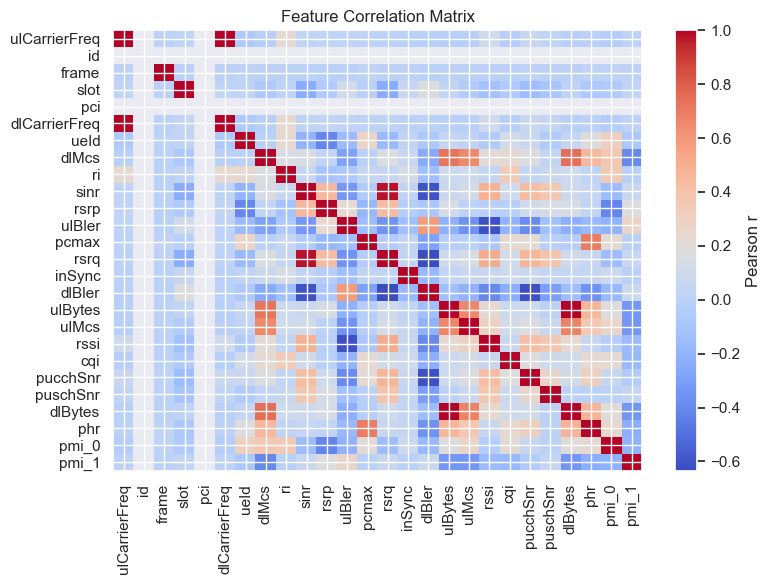

In [5]:
#Analysing the correlation between features (Only Numeric features)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols] .corr()
scaler = StandardScaler()
df1 = pd.DataFrame()
df1[numeric_cols] = scaler.fit_transform(df[numeric_cols])

#print("Correlation matrix:\n", corr)

# Visualize with a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

Removing 2% of outliers/Noisy data using Isolation Forest

In [6]:
from sklearn.ensemble import IsolationForest

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
iso = IsolationForest(contamination=0.01, random_state=42)
df['iforest_label'] = iso.fit_predict(df[numeric_cols])
# label = −1 is an outlier
n_iso = (df['iforest_label'] == -1).sum()
print("IsolationForest outliers:", n_iso, f"({n_iso/len(df):.2%})")

IsolationForest outliers: 1689 (1.00%)


In [7]:
df = df[df['iforest_label'] == 1].reset_index(drop=True) #keeping only inliners
df.drop(columns=['iforest_label'], inplace=True)

In [8]:
df.describe()

,ulCarrierFreq,id,frame,slot,pci,dlCarrierFreq,ueId,dlMcs,ri,sinr,...,ulBytes,ulMcs,rssi,cqi,pucchSnr,puschSnr,dlBytes,phr,pmi_0,pmi_1
count,1.671720e+05,167172.0,167172.000000,167172.000000,167172.0,1.671720e+05,167172.000000,167172.000000,167172.000000,167172.000000,...,1.671720e+05,167172.000000,167172.000000,167172.000000,167172.000000,167172.000000,1.671720e+05,167172.000000,167172.000000,167172.000000
mean,3.750306e+09,12345678.0,509.845471,10.709515,0.0,3.750306e+09,22.580516,10.139832,1.932644,21.165294,...,1.467366e+09,7.372090,77.384429,14.520045,14.363141,15.321190,6.683665e+08,53.555775,8.591182,0.597768
std,1.404990e+06,0.0,295.017824,6.528031,0.0,1.404990e+06,10.364159,7.632047,0.268342,7.940488,...,4.395379e+09,2.707526,6.998459,1.805117,5.032339,7.566763,1.814033e+09,7.887585,5.979025,0.545379
min,3.750240e+09,12345678.0,0.000000,2.000000,0.0,3.750240e+09,1.000000,0.000000,1.000000,-10.000000,...,0.000000e+00,0.000000,59.800000,1.000000,3.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,3.750240e+09,12345678.0,254.000000,4.000000,0.0,3.750240e+09,20.000000,6.000000,2.000000,23.500000,...,1.259912e+06,6.000000,75.000000,15.000000,13.000000,12.000000,4.649668e+05,52.000000,0.000000,0.000000
50%,3.750240e+09,12345678.0,507.000000,9.000000,0.0,3.750240e+09,22.000000,9.000000,2.000000,23.500000,...,8.041060e+06,6.000000,79.900000,15.000000,15.000000,16.000000,2.219774e+06,52.000000,11.000000,1.000000
75%,3.750240e+09,12345678.0,766.000000,19.000000,0.0,3.750240e+09,24.000000,9.000000,2.000000,23.500000,...,3.637968e+07,8.000000,81.500000,15.000000,16.000000,18.000000,1.211683e+08,52.000000,13.000000,1.000000
max,3.780300e+09,12345678.0,1023.000000,19.000000,0.0,3.780300e+09,69.000000,27.000000,4.000000,23.500000,...,2.275132e+10,27.000000,120.000000,15.000000,60.000000,63.500000,9.106684e+09,65.000000,15.000000,3.000000


In [9]:
#features in the data
df.columns

Index(['_id', 'ulCarrierFreq', 'timestamp', 'id', 'frame', 'slot', 'pci',
       'dlCarrierFreq', 'ueId', 'dlMcs', 'ri', 'sinr', 'rsrp', 'ulBler',
       'pcmax', 'rsrq', 'inSync', 'dlBler', 'ulBytes', 'ulMcs', 'rssi', 'cqi',
       'pucchSnr', 'puschSnr', 'rnti', 'dlBytes', 'phr', 'pmi_0', 'pmi_1'],
      dtype='object')

In [10]:
df['pcmax'].describe()

count    167172.000000
mean         23.648147
std           2.482160
min           0.000000
25%          24.000000
50%          24.000000
75%          24.000000
max          30.000000
Name: pcmax, dtype: float64

Considering the following features for user signature:
'rnti'
'rsrp'
'pucchSnr'
'rssi'
'ulBler'
'puschSnr'
'dlBler'
'rsrq'
'sinr'


In [11]:
to_drop = [
    '_id', 'id', 'ueId',  'cqi',    # network IDs
    'timestamp', 'frame', 'slot',       # timing/order markers
    'pci', 'ulCarrierFreq', 'dlCarrierFreq',  # cell/carrier config
    #'dlMcs', 'ulMcs', 'ri', 'pmi_0', 'pmi_1', 'phr', 'pcmax',  # control/scheduling
    #'ulBytes', 'dlBytes', 'inSync'     # traffic & state
]

df = df.drop(columns=to_drop, errors='ignore')

df.columns

Index(['dlMcs', 'ri', 'sinr', 'rsrp', 'ulBler', 'pcmax', 'rsrq', 'inSync',
       'dlBler', 'ulBytes', 'ulMcs', 'rssi', 'pucchSnr', 'puschSnr', 'rnti',
       'dlBytes', 'phr', 'pmi_0', 'pmi_1'],
      dtype='object')

In [12]:
df.head()

,dlMcs,ri,sinr,rsrp,ulBler,pcmax,rsrq,inSync,dlBler,ulBytes,ulMcs,rssi,pucchSnr,puschSnr,rnti,dlBytes,phr,pmi_0,pmi_1
0,9.0,1.0,12.0,-89.0,0.169858,22.0,-11.0,1.0,0.065610,4192.0,8.0,100.3,40.0,34.0,b39a,2413.0,50.0,0.0,0.0
1,9.0,1.0,11.5,-89.0,0.275585,22.0,-11.0,1.0,0.059049,5537.0,6.0,86.0,38.0,21.5,b39a,2831.0,52.0,0.0,0.0
2,9.0,1.0,11.5,-89.0,0.444611,22.0,-11.0,1.0,0.047830,7011.0,6.0,83.7,39.0,16.5,b39a,3265.0,52.0,0.0,0.0
3,9.0,1.0,11.5,-89.0,0.397827,22.0,-11.0,1.0,0.038742,8485.0,6.0,82.4,35.0,15.0,b39a,3683.0,52.0,0.0,0.0
4,9.0,1.0,11.5,-89.0,0.396927,22.0,-11.0,1.0,0.031381,9766.0,6.0,82.6,32.0,15.0,b39a,4334.0,52.0,0.0,0.0


In [13]:
raw_cols = ['dlMcs', 'ri', 'sinr', 'rsrp', 'ulBler', 'pcmax', 'rsrq', 'inSync',
       'dlBler', 'ulBytes', 'ulMcs', 'rssi', 'pucchSnr', 'puschSnr', 
       'dlBytes', 'phr', 'pmi_0', 'pmi_1']
scaler_raw = StandardScaler() # Normalise
df_scaled = pd.DataFrame() # A new DataFrame to work on
df_scaled[raw_cols] = scaler_raw.fit_transform(df[raw_cols])


In [14]:
df_scaled['rnti']= df['rnti'] 

In [15]:
df_scaled.head()

,dlMcs,ri,sinr,rsrp,ulBler,pcmax,rsrq,inSync,dlBler,ulBytes,ulMcs,rssi,pucchSnr,puschSnr,dlBytes,phr,pmi_0,pmi_1,rnti
0,-0.149349,-3.475588,-1.154252,-1.362237,-0.466089,-0.663999,0.0823,0.077223,-0.236657,-0.333843,0.231914,3.274384,5.094437,2.468541,-0.368442,-0.450808,-1.436891,-1.096062,b39a
1,-0.149349,-3.475588,-1.217220,-1.362237,-0.221125,-0.663999,0.0823,0.077223,-0.256792,-0.333843,-0.506770,1.231071,4.697006,0.816575,-0.368442,-0.197244,-1.436891,-1.096062,b39a
2,-0.149349,-3.475588,-1.217220,-1.362237,0.170499,-0.663999,0.0823,0.077223,-0.291221,-0.333842,-0.506770,0.902426,4.895722,0.155788,-0.368442,-0.197244,-1.436891,-1.096062,b39a
3,-0.149349,-3.475588,-1.217220,-1.362237,0.062103,-0.663999,0.0823,0.077223,-0.319111,-0.333842,-0.506770,0.716670,4.100860,-0.042448,-0.368441,-0.197244,-1.436891,-1.096062,b39a
4,-0.149349,-3.475588,-1.217220,-1.362237,0.060018,-0.663999,0.0823,0.077223,-0.341701,-0.333842,-0.506770,0.745248,3.504714,-0.042448,-0.368441,-0.197244,-1.436891,-1.096062,b39a


CREATING TIME WINDOWED SEQUENCES for each window: the mean of the features and their corresponding correalations are captured

In [16]:
sig_df = df_scaled.copy()

In [17]:
sig_df.columns

Index(['dlMcs', 'ri', 'sinr', 'rsrp', 'ulBler', 'pcmax', 'rsrq', 'inSync',
       'dlBler', 'ulBytes', 'ulMcs', 'rssi', 'pucchSnr', 'puschSnr', 'dlBytes',
       'phr', 'pmi_0', 'pmi_1', 'rnti'],
      dtype='object')

In [18]:
sig_df.describe()

,dlMcs,ri,sinr,rsrp,ulBler,pcmax,rsrq,inSync,dlBler,ulBytes,ulMcs,rssi,pucchSnr,puschSnr,dlBytes,phr,pmi_0,pmi_1
count,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05
mean,2.284999e-16,3.515905e-16,1.526733e-16,-2.176189e-16,4.352378e-17,-4.719610e-16,1.679746e-16,6.283746e-16,-9.928863e-17,9.520827e-18,1.237708e-16,-1.479809e-15,-9.520827e-17,3.332290e-17,4.624402e-17,-8.598497e-17,1.298913e-16,4.080355e-17
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-1.328590e+00,-3.475588e+00,-3.924871e+00,-4.100532e+00,-8.596406e-01,-9.527275e+00,-4.462672e+00,-1.294953e+01,-4.380053e-01,-3.338440e-01,-2.722822e+00,-2.512622e+00,-2.258030e+00,-2.024807e+00,-3.684434e-01,-6.789902e+00,-1.436891e+00,-1.096062e+00
25%,-5.424291e-01,2.510078e-01,2.940264e-01,-5.407482e-01,-8.589779e-01,1.417533e-01,2.799073e-01,7.722291e-02,-4.380053e-01,-3.335574e-01,-5.067704e-01,-3.407088e-01,-2.708770e-01,-4.389195e-01,-3.681871e-01,-1.972441e-01,-1.436891e+00,-1.096062e+00
50%,-1.493486e-01,2.510078e-01,2.940264e-01,6.910766e-03,-6.098263e-01,1.417533e-01,2.799073e-01,7.722291e-02,-4.379992e-01,-3.320146e-01,-5.067704e-01,3.594475e-01,1.265537e-01,8.970968e-02,-3.672197e-01,-1.972441e-01,4.028793e-01,7.375302e-01
75%,-1.493486e-01,2.510078e-01,2.940264e-01,8.283992e-01,1.456914e+00,1.417533e-01,2.799073e-01,7.722291e-02,-3.316253e-01,-3.255672e-01,2.319136e-01,5.880699e-01,3.252690e-01,3.540243e-01,-3.016482e-01,-1.972441e-01,7.373830e-01,7.375302e-01
max,2.209134e+00,7.704199e+00,2.940264e-01,3.155950e+00,1.538399e+00,2.559010e+00,2.799073e-01,7.722291e-02,2.690684e+00,4.842363e+00,7.249411e+00,6.089297e+00,9.068744e+00,6.367182e+00,4.651703e+00,1.450921e+00,1.071887e+00,4.404714e+00


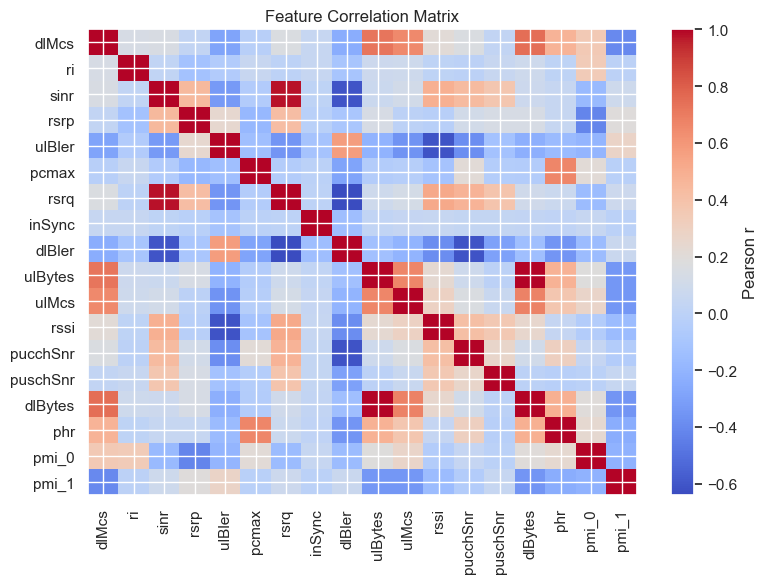

In [19]:

numeric_cols = sig_df.select_dtypes(include=[np.number]).columns.tolist()
corr = sig_df[numeric_cols].corr()
scaler = StandardScaler()
df_c = pd.DataFrame()
df_c[numeric_cols] = scaler.fit_transform(sig_df[numeric_cols])

#print("Correlation matrix:\n", corr)

# Visualize with a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [20]:
constant_cols = [col for col in numeric_cols if sig_df[col].nunique() <= 1]
print("Constant columns:", constant_cols)

Constant columns: []


In [21]:
# Get average absolute correlation of each feature with others
mean_corr = corr.abs().mean().sort_values()

print("Features with lowest mean correlation:")
print(mean_corr.head(10))


Features with lowest mean correlation:
inSync      0.093380
ri          0.122577
pcmax       0.176705
puschSnr    0.178976
rsrp        0.208345
pmi_1       0.214802
pmi_0       0.235220
pucchSnr    0.268304
phr         0.279268
rssi        0.289145
dtype: float64


In [22]:
low_corr_pairs = []
for col in corr.columns:
    for row in corr.index:
        if col != row and abs(corr.loc[row, col]) < 0.05:
            low_corr_pairs.append((row, col, corr.loc[row, col]))

# View top 10 uncorrelated pairs
print("Low-correlation feature pairs:")
for a, b, val in low_corr_pairs[:10]:
    print(f"{a} vs {b}: r = {val:.2f}")


Low-correlation feature pairs:
rsrp vs dlMcs: r = 0.03
pcmax vs dlMcs: r = -0.02
inSync vs dlMcs: r = 0.05
puschSnr vs dlMcs: r = 0.03
sinr vs ri: r = 0.02
rsrq vs ri: r = 0.01
inSync vs ri: r = 0.05
rssi vs ri: r = 0.01
pucchSnr vs ri: r = -0.00
phr vs ri: r = 0.01


In [23]:
sig_df.columns

Index(['dlMcs', 'ri', 'sinr', 'rsrp', 'ulBler', 'pcmax', 'rsrq', 'inSync',
       'dlBler', 'ulBytes', 'ulMcs', 'rssi', 'pucchSnr', 'puschSnr', 'dlBytes',
       'phr', 'pmi_0', 'pmi_1', 'rnti'],
      dtype='object')

In [24]:
n_total = len(sig_df)

# number of windows with any NaN
n_with_nan = sig_df.isna().any(axis=1).sum()

print(f"{n_with_nan} out of {n_total} windows ({n_with_nan/n_total:.1%}) have at least one NaN")

0 out of 167172 windows (0.0%) have at least one NaN


In [25]:
nan_per_col = sig_df.isna().sum().sort_values(ascending=False)
print(nan_per_col)

dlMcs       0
ulMcs       0
pmi_1       0
pmi_0       0
phr         0
dlBytes     0
puschSnr    0
pucchSnr    0
rssi        0
ulBytes     0
ri          0
dlBler      0
inSync      0
rsrq        0
pcmax       0
ulBler      0
rsrp        0
sinr        0
rnti        0
dtype: int64


In [26]:
sig_df = sig_df.fillna(0)
sig_df

,dlMcs,ri,sinr,rsrp,ulBler,pcmax,rsrq,inSync,dlBler,ulBytes,ulMcs,rssi,pucchSnr,puschSnr,dlBytes,phr,pmi_0,pmi_1,rnti
0,-0.149349,-3.475588,-1.154252,-1.362237,-0.466089,-0.663999,0.082300,0.077223,-0.236657,-0.333843,0.231914,3.274384,5.094437,2.468541,-0.368442,-0.450808,-1.436891,-1.096062,b39a
1,-0.149349,-3.475588,-1.217220,-1.362237,-0.221125,-0.663999,0.082300,0.077223,-0.256792,-0.333843,-0.506770,1.231071,4.697006,0.816575,-0.368442,-0.197244,-1.436891,-1.096062,b39a
2,-0.149349,-3.475588,-1.217220,-1.362237,0.170499,-0.663999,0.082300,0.077223,-0.291221,-0.333842,-0.506770,0.902426,4.895722,0.155788,-0.368442,-0.197244,-1.436891,-1.096062,b39a
3,-0.149349,-3.475588,-1.217220,-1.362237,0.062103,-0.663999,0.082300,0.077223,-0.319111,-0.333842,-0.506770,0.716670,4.100860,-0.042448,-0.368441,-0.197244,-1.436891,-1.096062,b39a
4,-0.149349,-3.475588,-1.217220,-1.362237,0.060018,-0.663999,0.082300,0.077223,-0.341701,-0.333842,-0.506770,0.745248,3.504714,-0.042448,-0.368441,-0.197244,-1.436891,-1.096062,b39a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167167,-0.542429,0.251008,-0.713471,-2.594469,1.457306,0.141753,0.082300,-12.949526,2.615981,-0.333815,-0.506770,-2.198266,-1.860600,-1.628335,-0.368433,-0.197244,-1.102387,0.737530,b078
167168,-0.542429,0.251008,-2.224718,-2.594469,1.441931,0.141753,-0.905737,0.077223,-0.051887,-0.333828,-0.506770,-0.112086,0.523984,-0.042448,-0.368430,0.690229,-1.436891,0.737530,93aa
167169,-0.542429,0.251008,-0.713471,-2.594469,1.457306,0.141753,0.082300,-12.949526,2.615981,-0.333815,-0.506770,-2.198266,-1.860600,-1.628335,-0.368433,-0.197244,-1.102387,0.737530,b078
167170,-0.542429,0.251008,-2.224718,-2.594469,1.451944,0.141753,-0.905737,0.077223,-0.090499,-0.333828,-0.506770,2.659961,0.126554,2.072069,-0.368430,0.690229,-1.436891,0.737530,93aa


In [27]:
#nan_frac = sig_df.isna().mean()

# 2. Choose a threshold (e.g. 0.5 for 50%)
#threshold = 0.5

# 3. Identify columns to drop vs keep
#drop_cols = nan_frac[nan_frac > threshold].index.tolist()
#keep_cols = nan_frac[n0.an_frac <= threshold].index.tolist()

#print(f"Dropping {len(drop_cols)} columns with >{threshold*100:.0f}% NaNs:")
#print(drop_cols)
#print(f"\nKeeping {len(keep_cols)} columns with ≤{threshold*100:.0f}% NaNs:")
#print(keep_cols)

In [28]:
#sig_df.drop(columns= drop_cols, inplace = True)

In [29]:
#sig_df.dropna(inplace = True)

In [30]:
sig_df.columns

Index(['dlMcs', 'ri', 'sinr', 'rsrp', 'ulBler', 'pcmax', 'rsrq', 'inSync',
       'dlBler', 'ulBytes', 'ulMcs', 'rssi', 'pucchSnr', 'puschSnr', 'dlBytes',
       'phr', 'pmi_0', 'pmi_1', 'rnti'],
      dtype='object')

APPLY K-Means CLustering on whole data to determine the number of clusters

In [32]:
X = sig_df.drop(columns = 'rnti').values
best_k = 3
# 2. Fit final k-means
km_final = KMeans(n_clusters=best_k, random_state=0, init='k-means++').fit(X)
labels   = km_final.labels_
centroids= km_final.cluster_centers_

# 3. Attach back to your sig_df
sig_df['kmeans_label'] = labels

PCA PROJECTION TO VISUALISE THE CLUSTERS ON 2 PRINCIPLE COMPONENTS

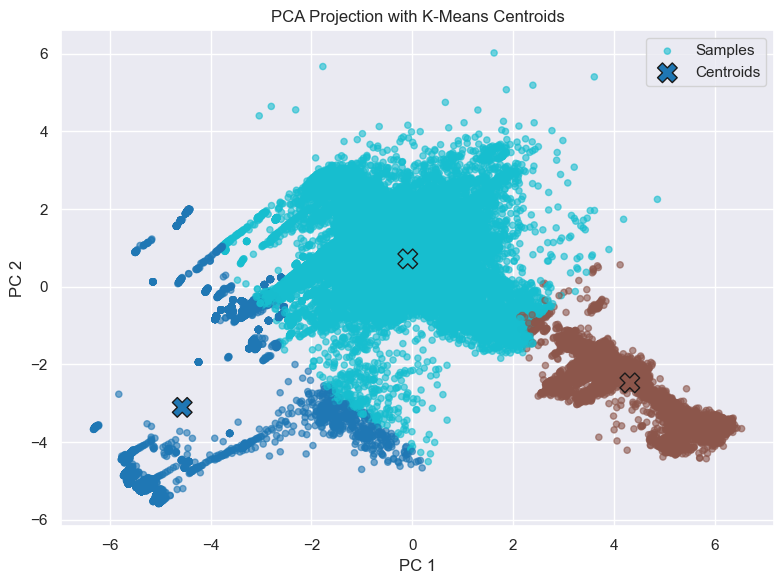

In [33]:
labels = sig_df['kmeans_label'].values        # or 'dbscan_label'

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# 2. Project centroids into the same PCA space
centroids = km_final.cluster_centers_               # shape (K, n_features)
centroids_pca = pca.transform(centroids)      # shape (K, 2)

# 3. Scatter plot of windows
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=labels,
    cmap='tab10',
    s=20,
    alpha=0.6,
    label="Samples"
)

# 4. Overlay centroids
plt.scatter(
    centroids_pca[:,0], centroids_pca[:,1],
    c=range(len(centroids_pca)),
    cmap='tab10',
    marker='X',
    s=200,
    edgecolor='k',
    label="Centroids"
)

plt.legend(loc='best')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA Projection with K-Means Centroids")
plt.tight_layout()
plt.show()


TSNE : NON LINEAR PROJECTION ON 2 COMPOENTNS

TESTING ON NEW DATA(AUTHENTIC AND NON-AUTHENTIC): READ the DATA FILES THAT You want to test on

In [34]:
#preprocessing test data

In [35]:
#authentic_1_noise_less_antennas.csv
#authentic_2_normal.csv
#authentic_3_obstacles.csv
#non_authentic_1_diff_position.csv
#non_authentic_2_less_antennas_diff_position.csv
#non_authentic_3_no_antennas.csv

In [36]:
df1 = pd.read_csv('non_authentic_2_less_antennas_diff_position.csv', sep=',', low_memory=False) # read the testing data files

In [37]:
df1.columns

Index(['ulCarrierFreq', 'timestamp', 'id', 'frame', 'slot', 'pci',
       'dlCarrierFreq', '_id.$oid', 'avgLdpcIterations', 'rnti', 'ulBytes',
       'pmi', 'rsrp', 'cqi', 'pucchSnr', 'rssi', 'ueId', 'inSync', 'dlBytes',
       'dlMcs', 'ulMcs', 'ulBler', 'ri', 'pcmax', 'puschSnr', 'dlBler', 'phr',
       'rsrq', 'sinr'],
      dtype='object')

In [38]:
#drop the Nan values and remove outliers using Isolation Forest

In [39]:
df1['pmi']

0        (15,1)
1        (13,1)
2        (15,1)
3        (15,1)
4        (15,1)
          ...  
37508    (15,0)
37509     (4,0)
37510    (14,0)
37511     (6,1)
37512    (15,0)
Name: pmi, Length: 37513, dtype: object

In [40]:
df1[['pmi_0', 'pmi_1']] = df1['pmi'].str.strip('()').str.split(',', expand=True).astype(int)
df1.drop(columns = 'pmi', inplace = True)

In [41]:
df1.dropna(inplace = True)
numeric_cols = df1.select_dtypes(include=[np.number]).columns.tolist()
iso = IsolationForest(contamination=0.01, random_state=42)
df1['iforest_label'] = iso.fit_predict(df1[numeric_cols])
# label = −1 is an outlier
n_iso = (df1['iforest_label'] == -1).sum()
print("IsolationForest outliers:", n_iso, f"({n_iso/len(df1):.2%})")
df1 = df1[df1['iforest_label'] == 1].reset_index(drop=True)
df1.drop(columns=['iforest_label'], inplace=True)

IsolationForest outliers: 205 (1.00%)


In [42]:
#Keep the features same as training data

to_drop = [
    '_id', 'id', 'ueId',  'cqi', '_id.$oid', 'avgLdpcIterations', 'pmi',  # network IDs
    'timestamp', 'frame', 'slot',       # timing/order markers
    'pci', 'ulCarrierFreq', 'dlCarrierFreq',  # cell/carrier config
    #'dlMcs', 'ulMcs', 'ri', 'pmi_0', 'pmi_1', 'phr', 'pcmax',  # control/scheduling
    #'ulBytes', 'dlBytes', 'inSync'     # traffic & state
]

df1 = df1.drop(columns=to_drop, errors='ignore')

print(df1.columns)
numeric_cols = df1.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler() # Normalise using StandardSCALER
df1[numeric_cols] = scaler.fit_transform(df1[numeric_cols])
print(df1.head())

Index(['rnti', 'ulBytes', 'rsrp', 'pucchSnr', 'rssi', 'inSync', 'dlBytes',
       'dlMcs', 'ulMcs', 'ulBler', 'ri', 'pcmax', 'puschSnr', 'dlBler', 'phr',
       'rsrq', 'sinr', 'pmi_0', 'pmi_1'],
      dtype='object')
   rnti   ulBytes      rsrp  pucchSnr      rssi    inSync   dlBytes     dlMcs  \
0  ff31 -1.000716 -0.405540  0.955061  1.082098  0.122686 -0.868409  1.743920   
1  ff31 -0.999081 -0.405540 -0.206840  1.577017  0.122686 -0.859040  1.281246   
2  ff31 -0.997984 -0.405540  0.606490  0.694770  0.122686 -0.855669  1.281246   
3  ff31 -0.996936 -0.331479  0.374110  1.426389  0.122686 -0.853142  1.281246   
4  ff31 -0.995314 -0.331479  0.374110  1.361835  0.122686 -0.851720  0.355896   

      ulMcs    ulBler        ri    pcmax  puschSnr    dlBler       phr  \
0 -0.016481 -0.924835 -0.260916 -0.10806  0.227453 -0.978223 -1.030902   
1 -0.016481 -1.050238 -0.260916 -0.10806  0.777767 -0.898686 -2.159184   
2 -0.016481 -0.148196 -0.260916 -0.10806 -0.001845 -0.857669  0.348110   

In [43]:
#prepare the time windowed sequences for test data
sig_df_test = df1.copy()

In [48]:
from sklearn.metrics import pairwise_distances

X = sig_df.drop(columns=['rnti','kmeans_label'], errors='ignore').values
X_new = sig_df_test.drop(columns='rnti', errors='ignore').values
print(X.shape)
print(X_new.shape)
# Train labels and assigned cluster distances
print(km_final.cluster_centers_.shape)
train_labels = km_final.labels_
train_dists = pairwise_distances(X, km_final.cluster_centers_)
train_assigned_dists = np.array([
    train_dists[i, label] for i, label in enumerate(train_labels)
])

# Per-cluster threshold
cluster_thresholds = {}
for k in range(km_final.n_clusters):
    dists_k = train_assigned_dists[train_labels == k]
    cluster_thresholds[k] = np.percentile(dists_k, 95)

# Predict on new data
new_labels = km_final.predict(X_new)
test_dists = pairwise_distances(X_new, km_final.cluster_centers_)

# Distances to assigned centroid
sig_df_test['new_dists'] = np.array([
    test_dists[i, new_labels[i]] for i in range(len(new_labels))
])

# Label based on distance to assigned cluster centroid
sig_df_test['authenticity'] = [
    'authentic' if sig_df_test['new_dists'][i] <= cluster_thresholds[new_labels[i]] else 'non_authentic'
    for i in range(len(new_labels))
]

(167172, 18)
(20231, 18)
(3, 18)


In [49]:
cluster_thresholds

{0: 10.103697153457118, 1: 3.236693146584464, 2: 4.92868542524548}

In [50]:
sig_df_test

,rnti,ulBytes,rsrp,pucchSnr,rssi,inSync,dlBytes,dlMcs,ulMcs,ulBler,...,pcmax,puschSnr,dlBler,phr,rsrq,sinr,pmi_0,pmi_1,new_dists,authenticity
0,ff31,-1.000716,-0.405540,0.955061,1.082098,0.122686,-0.868409,1.743920,-0.016481,-0.924835,...,-0.108060,0.227453,-0.978223,-1.030902,0.262651,-0.093989,1.048500,0.183704,3.248377,authentic
1,ff31,-0.999081,-0.405540,-0.206840,1.577017,0.122686,-0.859040,1.281246,-0.016481,-1.050238,...,-0.108060,0.777767,-0.898686,-2.159184,0.262651,-0.093989,1.048500,0.183704,3.840143,authentic
2,ff31,-0.997984,-0.405540,0.606490,0.694770,0.122686,-0.855669,1.281246,-0.016481,-0.148196,...,-0.108060,-0.001845,-0.857669,0.348110,0.262651,-0.093989,1.048500,0.183704,2.491902,authentic
3,ff31,-0.996936,-0.331479,0.374110,1.426389,0.122686,-0.853142,1.281246,-0.016481,0.399115,...,-0.108060,0.594329,-0.895926,-0.153349,0.262651,-0.093989,1.048500,0.183704,2.884779,authentic
4,ff31,-0.995314,-0.331479,0.374110,1.361835,0.122686,-0.851720,0.355896,-0.016481,0.369794,...,-0.108060,0.456750,-0.739205,-1.908454,0.262651,-0.035852,1.048500,0.183704,3.282237,authentic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20226,6695,-0.589180,-0.479601,0.257920,1.082098,0.122686,-0.310398,1.281246,-0.016481,0.502289,...,0.887457,0.273312,-1.059026,-1.030902,0.262651,-0.152126,1.048500,-1.208249,3.325926,authentic
20227,30be,1.482676,1.668168,0.257920,0.888434,0.122686,2.150900,1.281246,-0.016481,-1.517917,...,-2.099093,0.456750,-1.059009,0.724204,0.550251,1.068755,-1.083263,-1.208249,5.546794,non_authentic
20228,23b3,1.150358,0.483192,0.141730,0.802361,0.122686,0.591792,-0.569453,-0.016481,0.692113,...,-0.108060,0.548470,-1.009529,0.724204,0.262651,0.487383,0.854703,-1.208249,3.158439,authentic
20229,308f,-0.284471,-1.886759,-1.020171,-0.477973,0.122686,-0.728263,-2.882825,-0.016481,0.692113,...,-0.108060,-0.919036,0.968769,-2.535278,-4.051347,-2.477614,-0.695669,0.183704,6.183856,authentic


In [51]:
print(sig_df_test['authenticity'].value_counts())

authenticity
authentic        15908
non_authentic     4323
Name: count, dtype: int64


In [52]:
explained_var = pca.explained_variance_ratio_
total_var = explained_var.sum()
print(total_var)

0.44562319346450346


In [53]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)  # X from your training data
centroids_pca = pca.transform(km_final.cluster_centers_)

In [54]:
X_new_pca = pca.transform(X_new)

C:\Users\madda\AppData\Local\Temp\ipykernel_2652\626343824.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\madda\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


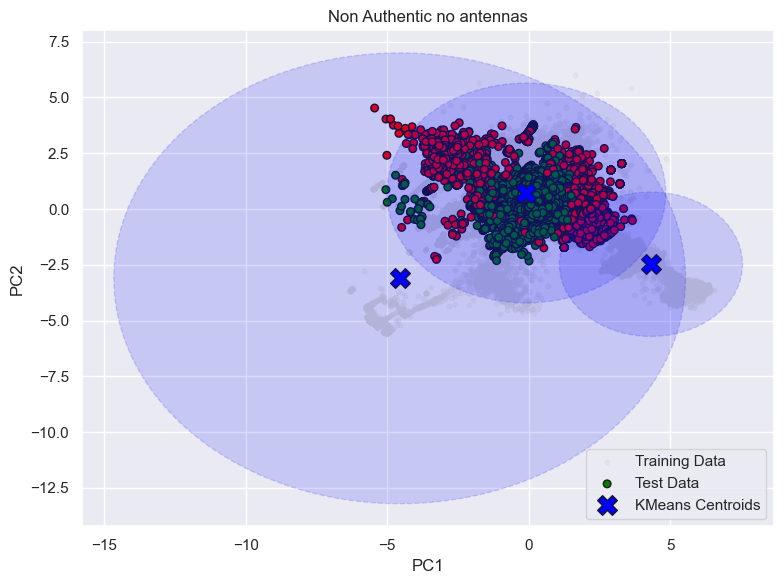

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot training data (light gray background)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgray', s=10, alpha=0.3, label='Training Data')

# Plot new test data points
color_map = {'authentic': 'green', 'non_authentic': 'red'}
colors = sig_df_test['authenticity'].map(color_map)

plt.scatter(X_new_pca[:, 0], X_new_pca[:, 1], c=colors, s=30, edgecolor='k', label='Test Data')

# Overlay centroids
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='blue', marker='X', s=200, edgecolor='k', label='KMeans Centroids'
)
for i, (cx, cy) in enumerate(centroids_pca):
    # Use per-cluster threshold if available; otherwise fallback to global
    radius = cluster_thresholds.get(i)
    
    # Optional: transform the threshold radius into PCA space — approximate by applying PCA to vector with that magnitude
    #unit_vec = km_final.cluster_centers_[i] + radius * np.ones(km_final.cluster_centers_.shape[1])
    #transformed_vec = pca.transform([unit_vec])[0]
    #scaled_radius = ((transformed_vec - centroids_pca[i])**2).sum()**0.5

    circle = Circle((cx, cy), radius, color='blue', alpha=0.15, linestyle='--', linewidth=1, fill=True)
    plt.gca().add_patch(circle)

plt.title('Non Authentic no antennas')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()